# Introduction
We are now ready to get to work. The following Notebook is all about preliminary data exploration. Starting with our improved *Metadata_Extended.csv*, we seek to answer some basic questions about the dataset we were given and pave the way for our qiime pipeline.
Some questions we want to answer with this Notebook are:

- did the two sequencing techniques generate different number of mags per sample?
- are all samples sequenced by both techniques?
- what is the genome size distribution of our datasets?
- compare n50 and L50 for two different techniques

other interesting questions are:  
- nation of origin distribution of samples?
- what foods types are sampled in what proportion?





## Setup

In [1]:
#set up environment
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
%matplotlib inline
import matplotlib.pyplot as plt

# create directories for the notebook. DO NOT change
raw_data = 'data/raw'
metadata_dir = 'data/processed/metadata'

# fetches useful files for the current notebook. All files will be saved in $data_dir
#!wget 'https://polybox.ethz.ch/index.php/s/nMa2WaWEDft3kMr/download' -O data/Download.zip
#!unzip -o data/Download.zip -d data
#!rm data/Download.zip

In [2]:
%%bash -s "$raw_data" "$metadata_dir"
mkdir -p "$1"
mkdir -p "$2"

## importing Metadata_Expanded

In [3]:
metadata = pd.read_csv(f'{metadata_dir}/Metadata_Extended.tsv', sep='\t')
metadata.head(3) # Let's take a quick peek

,sample-id,mag-id,sample,samp_country,category,fermented_food_type,file_path
0,PB_B039_Aa_Gp_La,5b983d48-e6aa-43a3-a133-788d3c1f1f7d,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/5b983d48...
1,PB_B039_Aa_Gp_La,d7d759fe-db6f-4a63-85e8-b0666d7fe7df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/d7d759fe...
2,PB_B039_Aa_Gp_La,ccdfd5a4-34d9-4fd4-82f6-d3ecb0912675,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/ccdfd5a4...


# Exploration
## Question 1: Mags per sample compared
It is important to compare sequencing techniques retrieved MAGs on a per-sample basis as they may represent differences in read depth and quality, which is one of the questions we aim to answer for our project. Visualizing how the MAGs are distributed is also useful to acknowledje possible batch effect due to the different sample size down the line.

In [4]:
metadata.size

9982

In [5]:
# Group metadata by sample and sample-id, optaining a frequency per sample per technique
counts = metadata.groupby(['sample', 'sample-id']).size().reset_index(name='count')

In [6]:
# IL subset
IL = counts[counts['sample-id'].str.startswith('IL_')]

# PB subset
PB = counts[counts['sample-id'].str.startswith('PB_')]

A barplot showing the frequencies of both techniques per sample is a good way to visualize our dataset

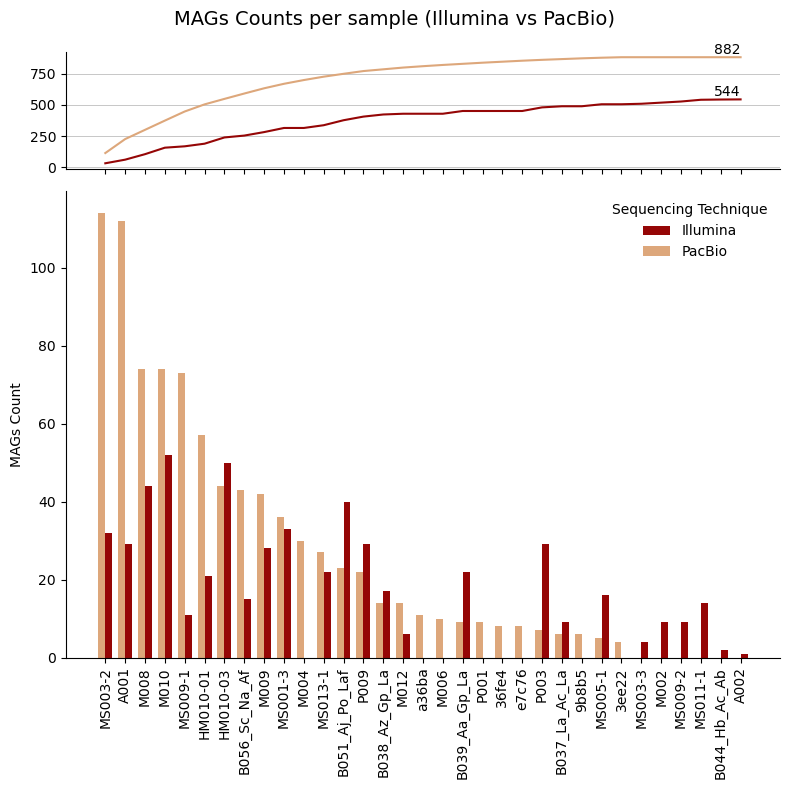

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Merge IL and PB counts
merged = IL[['sample', 'count']].rename(columns={'count':'IL_count'}).merge(
    PB[['sample', 'count']].rename(columns={'count':'PB_count'}),
    on='sample', how='outer'
).fillna(0)

# Sort by PB_count descending
merged = merged.sort_values('PB_count', ascending=False)

samples = merged['sample']
x = np.arange(len(samples))
width = 0.35

# Plot barplots
fig, (cum, ax) = plt.subplots(2,1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
ax.bar(x + width/2, merged['IL_count'], width, label='Illumina', color = '#950606')
ax.bar(x - width/2, merged['PB_count'], width, label='PacBio', color = '#DDA77B')

#Plot cumulative line plot
cumulative_IL = merged['IL_count'].cumsum()
cumulative_PB = merged['PB_count'].cumsum()
cum.plot(x, cumulative_IL, linewidth=1.5, color = '#950606')
cum.plot(x, cumulative_PB, linewidth=1.5, color = '#DDA77B')
last_x = x[-1]

#Plot cumulative sum
# IL label
cum.text(
    last_x,
    cumulative_IL.iloc[-1],
    str(int(cumulative_IL.iloc[-1])),
    va='bottom',
    ha='right'
)
# PB label
cum.text(
    last_x,
    cumulative_PB.iloc[-1],
    str(int(cumulative_PB.iloc[-1])),
    va='bottom',
    ha='right'
)


# hide borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cum.spines['top'].set_visible(False)
cum.spines['right'].set_visible(False)

#Axis lables
ax.set_xticks(x)
ax.set_xticklabels(samples, rotation=90)
ax.set_ylabel('MAGs Count')
fig.suptitle('MAGs Counts per sample (Illumina vs PacBio)', fontsize=14)
ax.legend(title='Sequencing Technique', frameon=False)
cum.grid(axis='y', linestyle='-', linewidth=0.5)

##show plot
plt.tight_layout()
plt.savefig("data/Visualizations/MAGs_count_per_sample.svg", transparent=True)
plt.show()


## Question 2: Are all samples sequenced by both techniques?
The next step is to divide an count for each sample how many *sample-id* start with IL or PB prefix and summarize the results in a graphic visualization

In [26]:
# Number of unique samples
num_unique_samples = counts['sample'].nunique()

# Count samples that have both IL and PB entries
# First, create flags for IL and PB
flags = counts.assign(
    is_IL = counts['sample-id'].str.startswith('IL_'),
    is_PB = counts['sample-id'].str.startswith('PB_')
)

# Aggregate by sample to see if both exist
agg = flags.groupby('sample')[['is_IL','is_PB']].any()

num_samples_both = (agg['is_IL'] & agg['is_PB']).sum()

num_unique_samples, num_samples_both


KeyError: "Columns not found: 'PacBio', 'Illumina'"

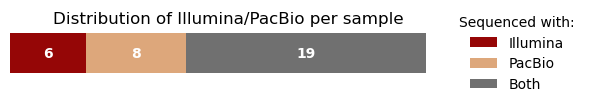

In [29]:
import matplotlib.pyplot as plt

# Categories
agg['category'] = 'Neither'
agg.loc[agg['is_IL'] & ~agg['is_PB'], 'category'] = 'Illumina'
agg.loc[~agg['is_IL'] & agg['is_PB'], 'category'] = 'PacBio'
agg.loc[agg['is_IL'] & agg['is_PB'], 'category'] = 'Both'

counts_per_category = agg['category'].value_counts()
categories = ['Illumina', 'PacBio', 'Both']  # control order
counts_ordered = counts_per_category.reindex(categories, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,1))
bottom = 0
colors = ['#950606','#DDA77B','#707070']

for cat, color in zip(categories, colors):
    value = counts_ordered[cat]
    ax.barh(0, value, left=bottom, label=cat, color=color)
    # Add count label inside the bar
    if value > 0:
        ax.text(bottom + value/2, 0, str(value), ha='center', va='center', color='white', fontweight='bold')
    bottom += value

# hide borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_yticks([])  # remove y-axis
ax.set_xticks([])  # remove x-axis
ax.set_title('Distribution of Illumina/PacBio per sample')
ax.legend(title='Sequenced with:', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("data/Visualizations/Distribution_Technique_per_sample.svg", transparent=True)
plt.show()


## Genome Size Distribution

## N50 and L50
N50 and L50 are important metrics to assess the quality and contiguity of the MAGs. Understanding the distribution of these metrics across the two sequencing techniques could provide insight in disparities in assembly quality. Since no contigs file are provided, the code must measure the lenght by deriving it directly from the MAGs .fa files. Functionally, it must do 3 things
1. cycle through all .fa files in all sample folders in /data/raw/sample_data.
2. for each mag, use SeqIO to measure the lenght of sequence (sequences are separated by a row starting with '>')
3. order the sequences by decreasing lenght and calculate the half lenght of the mag
4. count how many sequences are needed to cover half lenght (L50) and how long is the contigs that passes the half lenght (N50)

In [10]:
import os
import pandas as pd
from Bio import SeqIO

base_dir = f"{raw_data}/sample_data"

data = []

# 1 Loop through each folder in sample_data
for sample in os.listdir(base_dir):
    sample_path = os.path.join(base_dir, sample)
    if not os.path.isdir(sample_path):
        continue

    # Loop through each .fa file
    for fa_file in os.listdir(sample_path):
        if not fa_file.endswith(".fa"):
            continue
        
        fa_path = os.path.join(sample_path, fa_file)
        mag_id = os.path.splitext(fa_file)[0]  # filename without extension

# 2 measure the lenght of sequence      
        lengths = [len(rec.seq) for rec in SeqIO.parse(fa_path, "fasta")]
        if not lengths:
            continue

# 3 Sort in descending order
        lengths.sort(reverse=True)
        total_length = sum(lengths)
        half_total = total_length / 2
        
# 4 Calculate N50 and L50
        cumsum = 0
        L50 = 0
        N50 = 0
        for l in lengths:
            cumsum += l
            L50 += 1
            if cumsum >= half_total:
                N50 = l
                break
        
        data.append({
            "mag-id": mag_id,
            "N50": N50,
            "L50": L50
        })

# Save it as df
quality_stats = pd.DataFrame(data)
quality_stats.head(3)

,mag-id,N50,L50
0,9d11319f-d728-41cf-9964-99dd4811e124,4877,38
1,535f4f93-4dd1-4599-8e3a-2e99773bff19,176693,1
2,043b156d-74ca-439a-80ee-0c2f8b9a3398,145485,1


In [11]:
#merge it with the metadata do acquire sample identity
quality_stats_merged = metadata.merge(quality_stats, on = 'mag-id', how = 'left')
quality_stats_merged.head(3)

,sample-id,mag-id,sample,samp_country,category,fermented_food_type,file_path,N50,L50
0,PB_B039_Aa_Gp_La,5b983d48-e6aa-43a3-a133-788d3c1f1f7d,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/5b983d48...,80729,13
1,PB_B039_Aa_Gp_La,d7d759fe-db6f-4a63-85e8-b0666d7fe7df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/d7d759fe...,135983,2
2,PB_B039_Aa_Gp_La,ccdfd5a4-34d9-4fd4-82f6-d3ecb0912675,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/ccdfd5a4...,273871,5


As a sanity check NaN values in N50 and L50 can be checked. Since the new df has been merged to the metadata 'on the left', errors in the loops or the measurment should result in empty values for those mag-ids.

In [12]:
nan_rows = quality_stats_merged[quality_stats_merged['N50'].isna() | quality_stats_merged['L50'].isna()]

if nan_rows.empty:
    print("No NaN values in N50 or L50 columns.")
else:
    print(f"Found {len(nan_rows)} rows with NaN values:")
    print(nan_rows)

No NaN values in N50 or L50 columns.


As no NaN values was found, we can be certain that the metrics for every mag-id has been measured. Like before, the next step is to divide them into subsets for the Illumina and PacBio techniques. 

In [13]:
# IL subset
IL = quality_stats_merged[quality_stats_merged['sample-id'].str.startswith('IL_')]

# PB subset
PB = quality_stats_merged[quality_stats_merged['sample-id'].str.startswith('PB_')]

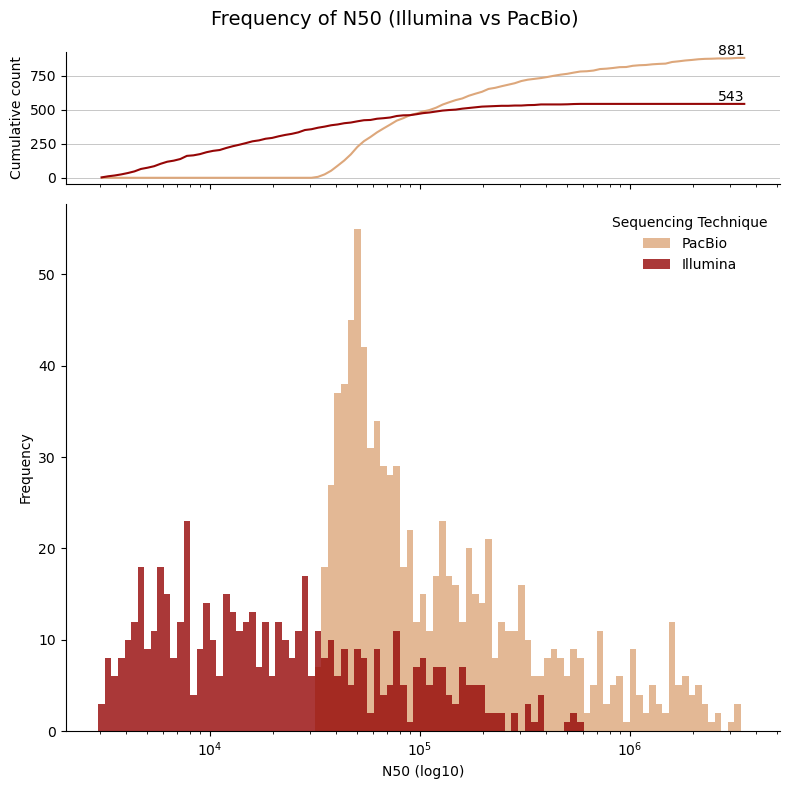

In [34]:
import numpy as np
import matplotlib.pyplot as plt

IL_n50 = IL['N50'].dropna().values
PB_n50 = PB['N50'].dropna().values

# Log-spaced bins
all_n50 = np.concatenate([IL_n50, PB_n50])
bins = np.logspace(np.log10(all_n50.min()), np.log10(all_n50.max()), 100)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

# Histogram counts
IL_counts, _ = np.histogram(IL_n50, bins=bins)
PB_counts, _ = np.histogram(PB_n50, bins=bins)

# Cumulative counts
IL_cum = np.cumsum(IL_counts)
PB_cum = np.cumsum(PB_counts)

# Figure layout
fig, (cum, ax) = plt.subplots(
    2, 1,
    figsize=(8, 8),
    sharex=True,
    gridspec_kw={'height_ratios': [1, 4]}
)

# --- Cumulative (top) ---
cum.plot(bin_centers, PB_cum, color='#DDA77B', linewidth=1.5)
cum.plot(bin_centers, IL_cum, color='#950606', linewidth=1.5)
cum.set_ylabel('Cumulative count')

# Add text labels at the last point
last_x = bin_centers[-1]
cum.text(
    last_x,
    IL_cum[-1],
    str(int(IL_cum[-1])),
    va='bottom',
    ha='right'
)
cum.text(
    last_x,
    PB_cum[-1],
    str(int(PB_cum[-1])),
    va='bottom',
    ha='right'
)

# --- Histogram (bottom) ---
ax.hist(PB_n50, bins=bins, alpha=0.8, color='#DDA77B', label='PacBio')
ax.hist(IL_n50, bins=bins, alpha=0.8, color='#950606', label='Illumina')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cum.spines['top'].set_visible(False)
cum.spines['right'].set_visible(False)
cum.grid(axis='y', linestyle='-', linewidth=0.5)

fig.suptitle('Frequency of N50 (Illumina vs PacBio)', fontsize=14)
ax.set_xscale('log')
ax.set_xlabel('N50 (log10)')
ax.set_ylabel('Frequency')
ax.legend(title='Sequencing Technique', frameon=False)

plt.tight_layout()
plt.savefig("data/Visualizations/N50.svg", transparent=True)
plt.show()


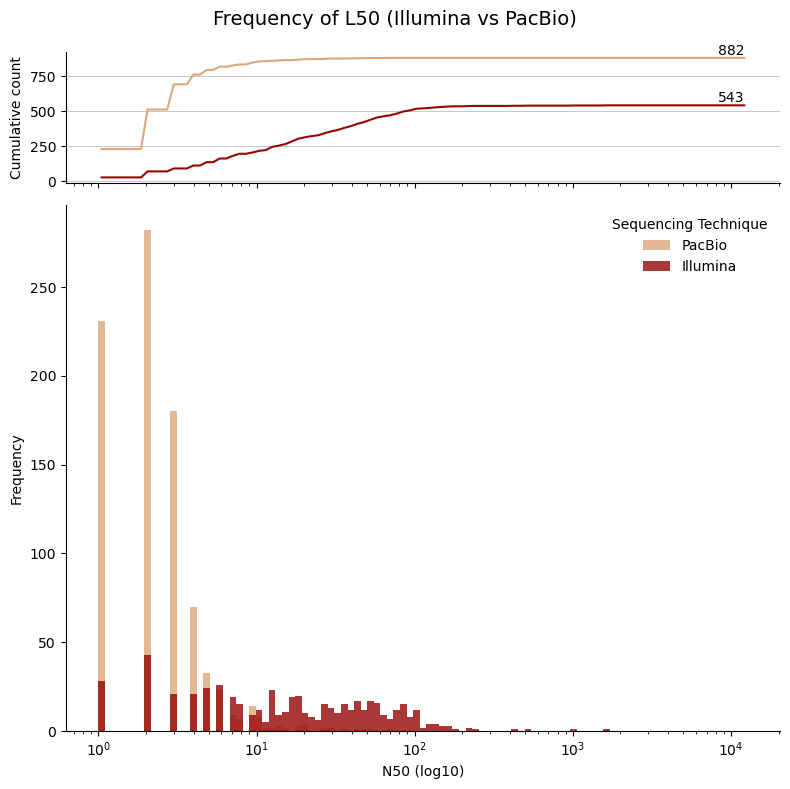

In [36]:
import numpy as np
import matplotlib.pyplot as plt

IL_n50 = IL['L50'].dropna().values
PB_n50 = PB['L50'].dropna().values

# Log-spaced bins
all_n50 = np.concatenate([IL_n50, PB_n50])
bins = np.logspace(np.log10(all_n50.min()), np.log10(all_n50.max()), 100)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

# Histogram counts
IL_counts, _ = np.histogram(IL_n50, bins=bins)
PB_counts, _ = np.histogram(PB_n50, bins=bins)

# Cumulative counts
IL_cum = np.cumsum(IL_counts)
PB_cum = np.cumsum(PB_counts)

# Figure layout
fig, (cum, ax) = plt.subplots(
    2, 1,
    figsize=(8, 8),
    sharex=True,
    gridspec_kw={'height_ratios': [1, 4]}
)

# --- Cumulative (top) ---
cum.plot(bin_centers, PB_cum, color='#DDA77B', linewidth=1.5)
cum.plot(bin_centers, IL_cum, color='#950606', linewidth=1.5)
cum.set_ylabel('Cumulative count')

# Add text labels at the last point
last_x = bin_centers[-1]
cum.text(
    last_x,
    IL_cum[-1],
    str(int(IL_cum[-1])),
    va='bottom',
    ha='right'
)
cum.text(
    last_x,
    PB_cum[-1],
    str(int(PB_cum[-1])),
    va='bottom',
    ha='right'
)

# --- Histogram (bottom) ---
ax.hist(PB_n50, bins=bins, alpha=0.8, color='#DDA77B', label='PacBio')
ax.hist(IL_n50, bins=bins, alpha=0.8, color='#950606', label='Illumina')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cum.spines['top'].set_visible(False)
cum.spines['right'].set_visible(False)
cum.grid(axis='y', linestyle='-', linewidth=0.5)

fig.suptitle('Frequency of L50 (Illumina vs PacBio)', fontsize=14)
ax.set_xscale('log')
ax.set_xlabel('N50 (log10)')
ax.set_ylabel('Frequency')
ax.legend(title='Sequencing Technique', frameon=False)
plt.tight_layout()
plt.savefig("data/Visualizations/L50.svg", transparent=True)
plt.show()


## Geographic Diversity
Understanding the Geographical context where the samples have been collected can be useful to interpret results. For example temperature and humidity combinations or geographical vicinity could be associated with composition features. 

Since a clear disparity already is visible in the MAGs per sample analysis, it would be interesting to see if the disparity is associated with the geographical location. To visualize this a MAGs/sample ration is plotted for each country

In [17]:
metadata.head(3)

,sample-id,mag-id,sample,samp_country,category,fermented_food_type,file_path
0,PB_B039_Aa_Gp_La,5b983d48-e6aa-43a3-a133-788d3c1f1f7d,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/5b983d48...
1,PB_B039_Aa_Gp_La,d7d759fe-db6f-4a63-85e8-b0666d7fe7df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/d7d759fe...
2,PB_B039_Aa_Gp_La,ccdfd5a4-34d9-4fd4-82f6-d3ecb0912675,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/ccdfd5a4...


since 

In [18]:
countries = metadata['samp_country'].unique()
countries_MAG_count = metadata.groupby('samp_country').size().reset_index(name='count')
countries_sample_count = metadata.groupby('samp_country')['sample'].nunique().reset_index(name='num_samples')

In [19]:
# Output is quiet because long and boring, if you wish to see the output remove the -q argument.
!pip install -q geopandas
!pip install -q adjustText

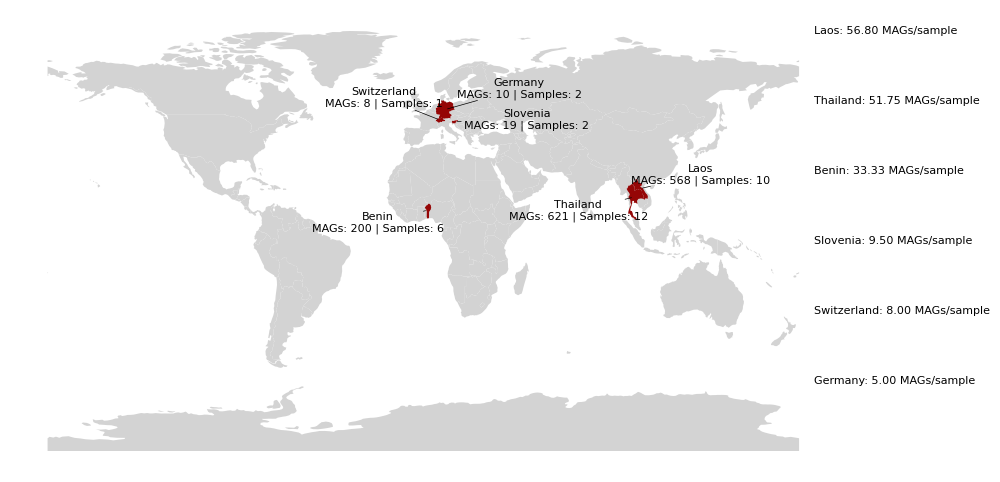

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from adjustText import adjust_text

#load map file
world = gpd.read_file('./additional_data/ne_110m_admin_0_countries.shp')

# Add countries to the highlight list to be colored afterward
world['highlight'] = world['NAME'].isin(countries)

# Add MAG counts
world = world.merge(
    countries_MAG_count.rename(columns={'count': 'mag_count'}),
    left_on='NAME', right_on='samp_country', how='left'
)

# Add sample counts
world = world.merge(
    countries_sample_count.rename(columns={'num_samples': 'sample_count'}),
    left_on='NAME', right_on='samp_country', how='left'
)

# Replace NaNs
world[['mag_count', 'sample_count']] = world[['mag_count', 'sample_count']].fillna(0)

# Compute MAGs per sample ratio
world['mag_per_sample'] = world.apply(
    lambda row: row['mag_count'] / row['sample_count'] if row['sample_count'] > 0 else 0,
    axis=1
)

#plot setup
fig, ax = plt.subplots(figsize=(14,6))

# Base map
world.plot(ax=ax, color='lightgray')

# Highlighted countries
world[world['highlight']].plot(ax=ax, color='#950606')

# Labels on countries
texts = []
for idx, row in world[world['highlight']].iterrows():
    label = f"{row['NAME']}\nMAGs: {int(row['mag_count'])} | Samples: {int(row['sample_count'])}"
    texts.append(
        ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            label,
            ha='center', va='center',
            fontsize=8
        )
    )

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', lw=0.5))

# MAGs per sample on the right side
right_x = world.geometry.total_bounds[2] + (world.geometry.total_bounds[2] - world.geometry.total_bounds[0])*0.02
highlighted_countries = world[world['highlight']].sort_values('mag_per_sample', ascending=False)

for i, row in enumerate(highlighted_countries.itertuples()):
    ax.text(
        right_x,
        world.geometry.total_bounds[3] - i*(world.geometry.total_bounds[3]-world.geometry.total_bounds[1])/len(highlighted_countries),
        f"{row.NAME}: {row.mag_per_sample:.2f} MAGs/sample",
        ha='left',
        va='center',
        fontsize=8,
        color='black'
    )

ax.set_axis_off()
plt.savefig("data/Visualizations/Countries.svg", transparent=True)
plt.show()


This map shows the geographic distribution of MAGs and samples across countries. The dataset is geographically and quantitatively biased, which limits its usefulness for studying global fermentation microbiomes. Any interpretation must consider these limitations and ideally include more samples from underrepresented regions. Lower MAG counts in Europe could be influenced by more hygienic or controlled fermentation.

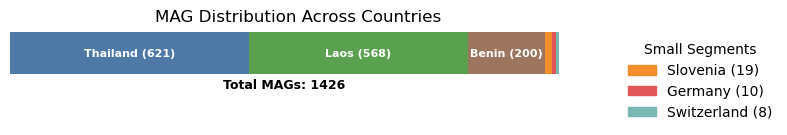

In [32]:
import matplotlib.pyplot as plt


df = countries_MAG_count.copy()
df = df.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(8, 1.2))

left = 0
colors = [
    "#4E79A7", "#59A14F", "#9C755F", "#F28E2B",
    "#E15759", "#76B7B2", "#B07AA1", "#EDC948",
    "#AF7AA1", "#FF9DA7", "#79706E", "#BAB0AC"
]
colors = colors[:len(df)]
# store small segments for legend
small_segments = []

for (country, count), color in zip(df[['samp_country','count']].values, colors):
    ax.barh(
        0,
        count,
        left=left,
        color=color,
        edgecolor='none'
    )

    if count > df['count'].sum() * 0.03:
        # label inside large segments
        ax.text(
            left + count/2,
            0,
            f"{country} ({int(count)})",
            ha='center',
            va='center',
            fontsize=8,
            color='white',
            fontweight='bold'
        )
    else:
        # store small segments for legend
        small_segments.append((country, color))
    
    left += count
    
# Add total MAGs below the bar
total_mags = df['count'].sum()
ax.text(
    0.5 * left,      # middle of the total bar
    -0.6,            # below the bar
    f"Total MAGs: {int(total_mags)}",
    ha='center',
    va='center',
    fontsize=9,
    fontweight='bold'
)

# Clean plot
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add legend for small segments
if small_segments:
    handles = [plt.Rectangle((0,0),1,1, color=color) for country, color in small_segments]
    labels = [f"{country} ({int(df.loc[df['samp_country']==country,'count'].values[0])})" 
              for country, color in small_segments]
    ax.legend(handles, labels, title="Small Segments", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

ax.set_title("MAG Distribution Across Countries")
plt.tight_layout()
plt.savefig("data/Visualizations/MAGs_per_Countrie.svg", transparent=True)
plt.show()


This plot represents the total number of metagenome-assembled genomes (MAGs) collected per country. It is clear that more than 80% of MAGs are from south-east asia, while less than 3% from Europe. The skewed MAG distribution can introduce bias, reduce representativeness, and affect downstream analyses, so it’s important to acknowledge it and, if possible, account for it (e.g., subsampling, weighting, or explicitly limiting conclusions to the sampled regions).

## Food-Type Diversity
Understanding the Type of food where the samples have been collected can be useful to interprete results. Different Food types likely have different composition that is beneficial for their preservation. This difference likely 

Since a clear disparity already is visible in the MAGs per sample analysis, it would be interesting to see if the disparity is associated with the food type. To visualize this a MAGs/sample ration is plotted for each food type same as the geographical analysis. 

In [22]:
metadata.head(3)

,sample-id,mag-id,sample,samp_country,category,fermented_food_type,file_path
0,PB_B039_Aa_Gp_La,5b983d48-e6aa-43a3-a133-788d3c1f1f7d,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/5b983d48...
1,PB_B039_Aa_Gp_La,d7d759fe-db6f-4a63-85e8-b0666d7fe7df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/d7d759fe...
2,PB_B039_Aa_Gp_La,ccdfd5a4-34d9-4fd4-82f6-d3ecb0912675,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin,data/raw/sample_data/PB_B039_Aa_Gp_La/ccdfd5a4...


In [23]:
foodtype_MAG_count = metadata.groupby('category').size().reset_index(name='count')
countries_sample_count = metadata.groupby('category')['sample'].nunique().reset_index(name='num_samples')

/tmp/ipykernel_6829/539265212.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels = [f"{food} ({int(df.loc[df['category']==food,'count'])})" for (food, color) in small_segments]


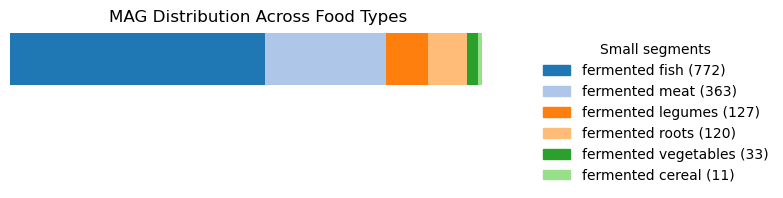

In [31]:
import matplotlib.pyplot as plt

df = foodtype_MAG_count.copy()
df = df.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(8, 1.5))

left = 0
colors = plt.cm.tab20(range(len(df)))
small_segments = []

for (food, count), color in zip(df[['category','count']].values, colors):
    ax.barh(
        0,
        count,
        left=left,
        color=color,
        edgecolor='none'
    )

    # label only if large enough
    if count > df['count'].sum() * 1:
        ax.text(
            left + count/2,
            0,
            f"{food} ({int(count)})",
            ha='center', va='center',
            fontsize=8,
            color='white',
            fontweight='bold'
        )
    else:
        small_segments.append((food, color))

    left += count

# clean up axes
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# legend for small segments
if small_segments:
    handles = [plt.Rectangle((0,0),1,1, color=color) for (food, color) in small_segments]
    labels = [f"{food} ({int(df.loc[df['category']==food,'count'])})" for (food, color) in small_segments]
    ax.legend(handles, labels, title="Small segments", frameon=False,
              bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("MAG Distribution Across Food Types")
plt.tight_layout()
plt.savefig(
    "data/Visualizations/Food_type_distribution.svg",
    transparent=True,
    bbox_inches="tight"
)
plt.show()


/tmp/ipykernel_6829/3743459647.py:45: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels = [f"{food} ({int(df.loc[df['category']==food,'num_samples'])})"


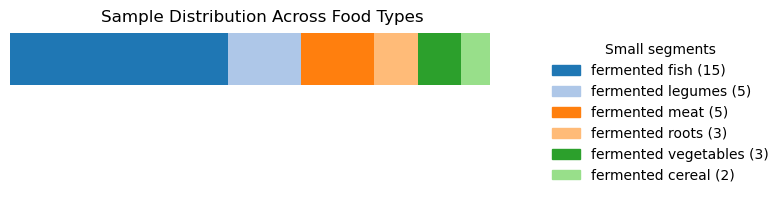

In [25]:
df = countries_sample_count.copy()
df = df.sort_values('num_samples', ascending=False)

fig, ax = plt.subplots(figsize=(8, 1.5))

left = 0
colors = plt.cm.tab20(range(len(df)))
small_segments = []

for (food, count), color in zip(df[['category','num_samples']].values, colors):
    ax.barh(
        0,
        count,
        left=left,
        color=color,
        edgecolor='none'
    )

    if count > df['num_samples'].sum() * 1:
        ax.text(
            left + count/2,
            0,
            f"{food} ({int(count)})",
            ha='center', va='center',
            fontsize=8,
            color='white',
            fontweight='bold'
        )
    else:
        small_segments.append((food, color))

    left += count

# clean axes
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# legend
if small_segments:
    handles = [plt.Rectangle((0,0),1,1, color=color) for (food, color) in small_segments]
    labels = [f"{food} ({int(df.loc[df['category']==food,'num_samples'])})"
              for (food, color) in small_segments]
    ax.legend(handles, labels, title="Small segments", frameon=False,
              bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Sample Distribution Across Food Types")
plt.tight_layout()
plt.savefig("data/Visualizations/Food_type_sample_distribution.svg", transparent=True)
plt.show()
